# About

This notebook will be the main evaluations of the models.

Credits to Garg et. al for the code, which we modified. The original source can be found [here](https://github.com/dtsip/in-context-learning)

In [11]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Displaying the directories
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
0,mamba,kernel_regression,mamba_kernel_regression,,-1,-1,5,12,NaN,mamba_kernel_regression
1,nanogpt,kernel_regression,nanogpt_kernel_regression,,-1,-1,5,12,8.0,nanogpt_kernel_regression


In [3]:
# Defining some hyperparameters for generating figures
task = "kernel_regression"
run_id_nanogpt = "nanogpt"
run_path_nanogpt = os.path.join(run_dir, task, run_id_nanogpt)

run_id_mamba = "mamba"
run_path_mamba = os.path.join(run_dir, task, run_id_mamba)

# Running Metrics

Recomputing metrics: getting nanoGPT and Mamba to run on the same dataset to get an equal comparison and also adding the distribution shifts

In [ ]:
get_run_metrics([run_path_nanogpt, run_path_mamba])

# Figure 1: Context Window Size vs. Squared Error

nanogpt_kernel_regression nanogpt


100%|██████████| 3/3 [00:00<00:00, 2985.27it/s]


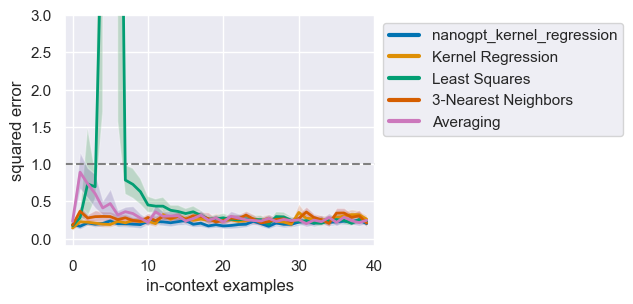

In [19]:
def valid_row(r):
    return r.task == task and r.run_id == run_id_nanogpt

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path_nanogpt, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task + "_" + run_id_nanogpt]
basic_plot(metrics["standard"], models=models)
plt.show()

# Figure 2: Context Window Size vs. Distribution Shifts

nanogpt_kernel_regression nanogpt


100%|██████████| 3/3 [00:00<?, ?it/s]


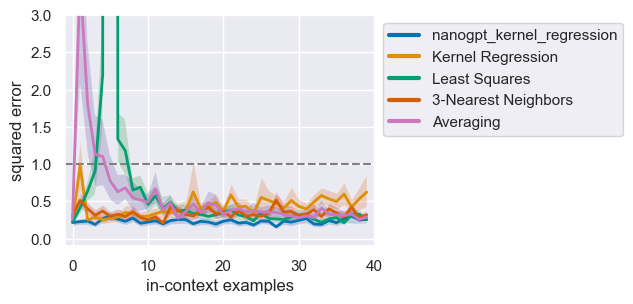

In [16]:
metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path_nanogpt, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task + "_" + run_id_nanogpt]
basic_plot(metrics["skewed"], models=models)
plt.show()

nanogpt_kernel_regression nanogpt


100%|██████████| 3/3 [00:00<?, ?it/s]


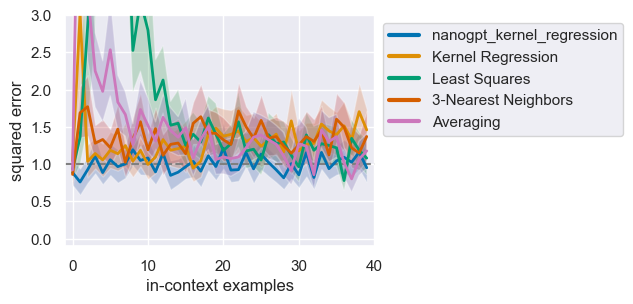

In [15]:
metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path_nanogpt, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task + "_" + run_id_nanogpt]
basic_plot(metrics["noisyKR"], models=models)
plt.show()

# Figure 3: ICL Regression Score